# Equilibrium runs
This example shows how to run the **V**olume/**A**rea **S**caling (VAS) model on a single glacier.

In [1]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# import the needed OGGM modules
import oggm
from oggm import cfg, utils, graphics
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, inversion, flowline, vascaling

In [2]:
# specify the RGI ID for Hintereisferner
rgi_id = 'RGI60-11.00897'
rgi_region = (rgi_id.split('-')[-1]).split('.')[0]
rgi_version = (rgi_id.split('-')[0])[-2:]

## Preprocessing

In [3]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = utils.gettempdir('VAS_HEF_wdir')
if not os.path.exists(wdir):
    os.makedirs(wdir)
shutil.rmtree(wdir)
os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 10
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-07-03 13:38:15: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


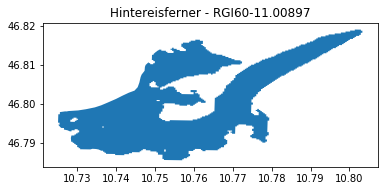

In [4]:
# read RGI entry for Hintereisferner as DataFrame
# containing the outline area as shapefile
entity = utils.get_rgi_glacier_entities([rgi_id])
# quick look, to make sure we got the rigth one
entity.plot()
plt.title('Hintereisferner - ' + rgi_id)
# select the row containing HEF from DataFrame
entity = entity.iloc[0]

In [5]:
# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

In [6]:
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, reset=True)

In [7]:
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

2019-07-03 13:38:17: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-07-03 13:38:17: oggm.core.gis: (RGI60-11.00897) glacier_masks


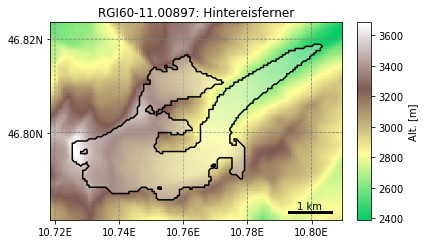

In [8]:
# view glacier domain and centerlines
graphics.plot_domain(gdir)

In [9]:
# process the given climate file
climate.process_histalp_data(gdir)
# compute mu star for HEF

2019-07-03 13:38:18: oggm.core.climate: (RGI60-11.00897) process_histalp_data


In [10]:
# no residual for equilibrium runs
cfg.PARAMS['use_bias_for_run'] = False

In [11]:
# compute mu* for HEF
vascaling.local_t_star(gdir)
# initialize constant massbalance model
mb_mod = vascaling.ConstantVASMassBalance(gdir)

2019-07-03 13:38:21: oggm.core.vascaling: (RGI60-11.00897) local_t_star


In [12]:
# reload the vas module
import importlib
importlib.reload(vascaling)
# read information from climate file and RGI
ci = gdir.read_pickle('climate_info')
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
# instance VAS model
model = vascaling.VAScalingModel(year_0=0, area_m2_0=gdir.rgi_area_m2,
                                 min_hgt=min_hgt, max_hgt=max_hgt,
                                 mb_model=mb_mod)

In [13]:
model.run_until_equilibrium(rate=1e-8)

In [14]:
print(model)

<class 'oggm.core.vascaling.VAScalingModel'>
year: 5
area [km2]: 8.04
volume [km3]: 0.596
length [km]: 4.89
min elev [m asl.]: 2430
spec mb [mm w.e. yr-1]: 0.00


## Run constant climate

In [16]:
vascaling.run_constant_climate(gdir, output_filesuffix='_constant')

2019-07-03 13:38:22: oggm.core.vascaling: (RGI60-11.00897) run_constant_climate_constant
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


<class 'oggm.core.vascaling.VAScalingModel'>: {'rho': 900.0, 'cl': 4.5507, 'ca': 0.191, 'ql': 2.2, 'gamma': 1.375, 'year_0': 0, 'year': 1000, 'area_m2_0': 8036000.0, 'area_m2': 8036000.309886597, 'min_hgt': 2429.9999696158097, 'min_hgt_0': 2430.0, 'max_hgt': 3685.0, 'volume_m3_0': 596297884.1715343, 'volume_m3': 596297912.2993476, 'length_m_0': 4894.636932668758, 'length_m': 4894.637051170415, 'mb_model': <oggm.core.vascaling.ConstantVASMassBalance object at 0x1c1e979f60>, 'spec_mb': 4.528414818548387e-05, 'dL': -2.73364959755183e-07, 'dA': -0.002142105431227675, 'dV': 0.40433714327611375, 'tau_a': 16.967294761092123, 'tau_l': 50.58405563546089}

In [17]:
vascaling.run_constant_climate(gdir, output_filesuffix='_constant_p', temperature_bias=0.5)

2019-07-03 13:38:27: oggm.core.vascaling: (RGI60-11.00897) run_constant_climate_constant_p
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


<class 'oggm.core.vascaling.VAScalingModel'>: {'rho': 900.0, 'cl': 4.5507, 'ca': 0.191, 'ql': 2.2, 'gamma': 1.375, 'year_0': 0, 'year': 1000, 'area_m2_0': 8036000.0, 'area_m2': 7108310.465806493, 'min_hgt': 2522.622971295521, 'min_hgt_0': 2430.0, 'max_hgt': 3685.0, 'volume_m3_0': 596297884.1715343, 'volume_m3': 503747461.3349807, 'length_m_0': 4894.636932668758, 'length_m': 4533.397238551964, 'mb_model': <oggm.core.vascaling.ConstantVASMassBalance object at 0x1c1f1064e0>, 'spec_mb': 0.004539735855594758, 'dL': 0.00023646882619472056, 'dA': 0.5454025907605788, 'dV': 35.855388242597236, 'tau_a': 16.709199190293102, 'tau_l': 48.30997222383564}

In [18]:
vascaling.run_constant_climate(gdir, output_filesuffix='_constant_n', temperature_bias=-0.5)

2019-07-03 13:38:31: oggm.core.vascaling: (RGI60-11.00897) run_constant_climate_constant_n
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


<class 'oggm.core.vascaling.VAScalingModel'>: {'rho': 900.0, 'cl': 4.5507, 'ca': 0.191, 'ql': 2.2, 'gamma': 1.375, 'year_0': 0, 'year': 1000, 'area_m2_0': 8036000.0, 'area_m2': 8989171.968475685, 'min_hgt': 2338.9216089903884, 'min_hgt_0': 2430.0, 'max_hgt': 3685.0, 'volume_m3_0': 596297884.1715343, 'volume_m3': 695659047.5501875, 'length_m_0': 4894.636932668758, 'length_m': 5249.852595141819, 'mb_model': <oggm.core.vascaling.ConstantVASMassBalance object at 0x1c1eb76cf8>, 'spec_mb': -0.009100144909274193, 'dL': -0.0005742628668634557, 'dA': -1.394728760270414, 'dV': -90.89197802194235, 'tau_a': 17.206497805007654, 'tau_l': 52.75541469022382}

In [19]:
ds_const = utils.compile_run_output([gdir], filesuffix='_constant')
ds_const_p = utils.compile_run_output([gdir], filesuffix='_constant_p')
ds_const_n = utils.compile_run_output([gdir], filesuffix='_constant_n')

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [32]:
# read t* from local_mustar file
t_star = gdir.read_json('vascaling_mustar')['t_star']

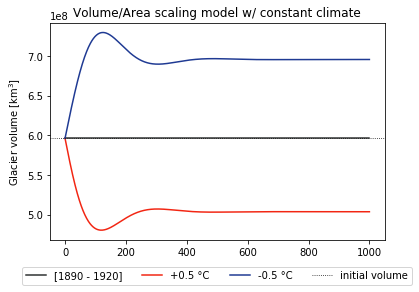

In [31]:
# create figure and axes
fig, ax0 = plt.subplots(1, 1,)
# plot the evolution of glacier volume
ax0.plot(ds_const.volume, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax0.plot(ds_const_p.volume, label='+0.5 °C', c='#f22613')
ax0.plot(ds_const_n.volume, label='-0.5 °C', c='#1f3a93')
ax0.axhline(ds_const.volume[0], c='k', ls=':', lw=0.8, label='initial volume')
ax0.set_ylabel('Glacier volume [km$^3$]')
ax0.set_title('Volume/Area scaling model w/ constant climate')
ax0.legend(ncol=4, bbox_to_anchor=(0.5, -0.1), loc=9)